<h1>Clustering</h1>

Clustering is an <b>unsupervised</b> group of algorithims which cluster 'similar' data points together. In this example, we are going to cluster together groups of pokemon based on their <b>'Battle Archetype'</b>. Clusters could represent different groups or demographics we are interested in within a dataset.

<b>What is a Battle Archetype?</b><br>

Short answer: a battle archetype is a category which best describes how a pokemon fits into a team and what it might be used for.<br>

Long Answer: In competitive pokemon battling, a pokemon is usually selected because it performs very well at a given role in a team. For example, the pokemon 'Gengar' is considered to be a special sweeper. This is because he has a high speed and high sp. atk stat, and his other stats are probably not that great. The pokemon 'Shuckle' is considered a stalling or wall pokemon, because it has low attack stats and speed but very high defensive stats.

The following methods will be covered using standard library functions, but there are others:<br>
k means<br>
Fuzzy C Means (FCM)<br>
Clustering Data Streams<br>
evolving clustering <br>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE #T distributed stochastic neighbour embedding
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

df_full = pd.read_csv("../input/Pokemon.csv")

print("setup and imports complete")

setup and imports complete


In [2]:
df_full.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


<h3>Data preperation and clean up</h3>

In [3]:
#build up a type list and include a type for none
type_list = df_full['Type 1'].unique().tolist()
type_list.append('none')
#replace NaN for 'Type 2' with 'none' so it will work with the LabelEncoder
df_full['Type 2'].fillna('none',inplace=True)

#use the label encoder to convert the type names, e.g 'Grass' into integers
le = LabelEncoder()
le.fit(type_list)
LabelEncoder()

df_full['Type 1'] = le.transform(df_full['Type 1'])
df_full['Type 2']  = le.transform(df_full['Type 2'])

features = ['#','Type 1','Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary']

In [4]:
#in Python, True is the integer 1 and False is the number 0. No further changes required.
df_full[features].sample(frac=1).head()

,#,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
305,282,14,518,68,65,65,125,115,80,3,False
112,104,10,320,50,50,95,40,50,35,1,False
718,650,9,313,56,61,65,48,45,38,6,False
419,381,2,600,80,90,80,130,110,110,3,True
469,422,17,325,76,48,48,57,62,34,4,False


<h3>K means clustering</h3>
The number of clusters must be decided by the person running the algorithm. A way to help find optimal number of clusters is an elbow plot. Another way is to start with 2 Clusters and add more clusters, checking the variance each time and seeing if they're equal.

Here's how it works in steps:<br><br>
<b>Step 1</b>: Choose the number of clusters to make. For instance k = 4 <br><br>
<b>Step 2</b>: then select 4 data points at random <br><br>
<b>Step 3</b>: measure the distance between the 1st data point and the initial clusters, and assign that point to the nearest cluster <br><br>
<b>Step 4</b>: start assiging the unassigned points. Measure the distance to the initial mean cluster points and assign the point to the nearest cluster. <br><br>
<b>Step 5</b>: Calculate the mean of each cluster, and then use the mean value as the point to measure the data points to, recluster the data. If the clusters change from one clustering to the next, this process continues. If the clusters do not change, the clustering will stop.<br><br>
<b>Step 6</b>: Once we have the 'final' cluster, we sum up the variation in the clustering and then repeat the process. K-means assumes that the variance in each cluster group is the same. So it is trying to make the clusters approximately the same size, with the same amount of variation in each group. The process finishes when it reaches this point.<br><br>
The example below will theoretically show us which pokemon are good special sweepers (and which are likely good physical attack sweepers).<br> <br>


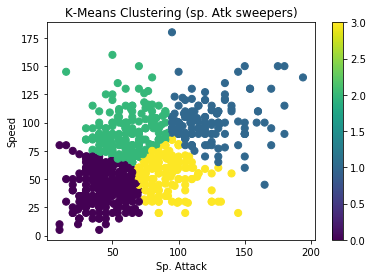

In [5]:
def GenKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = GenKmeans(df_full[['Sp. Atk','Speed']], 4)
kmeans = pd.DataFrame(clust_labels)
df_full.insert((df_full.shape[1]),'kmeans',kmeans)
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_full['Sp. Atk'],df_full['Speed'],c=kmeans[0],s=50)

ax.set_title('K-Means Clustering (sp. Atk sweepers)')
ax.set_xlabel('Sp. Attack')
ax.set_ylabel('Speed')

plt.colorbar(scatter)

In [7]:
#looking at the results of these two queries
#we can see the k-means = 4 has done a good job of clustering
#Special attack sweepers
df_full[(df_full['Speed'] > 120) & (df_full['Sp. Atk'] > 120)]

#probably physical attack sweepers
df_full[(df_full['Speed'] > 120) & (df_full['Sp. Atk'] < 80)]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,kmeans
19,15,BeedrillMega Beedrill,0,13,495,65,150,40,15,80,145,1,False,2
153,142,Aerodactyl,15,7,515,80,105,65,60,75,130,1,False,2
154,142,AerodactylMega Aerodactyl,15,7,615,80,135,85,70,95,150,1,False,2
183,169,Crobat,13,7,535,85,90,80,70,80,130,2,False,2
300,277,Swellow,12,7,430,60,85,60,50,50,125,3,False,2
315,291,Ninjask,0,7,456,61,90,45,50,50,160,3,False,2
476,428,LopunnyMega Lopunny,12,5,580,65,136,94,54,96,135,4,False,2
512,461,Weavile,1,11,510,70,120,65,45,85,125,4,False,2
716,648,MeloettaPirouette Forme,12,5,600,100,128,90,77,77,128,5,False,2
731,663,Talonflame,6,7,499,78,81,71,74,69,126,6,False,2


<h4>Identifying the optimal number of clusters with elbow plots</h4>
As more clusters are added, the average distance from data points to their mean centroids reduces.<br>
We can use this to our advantage to find out the number of clusters where we can see adding an extra cluster does not reduce the distance much.<br><br> The graph is called an elbow graph because of the obtuse angle the line makes as the sum of squares reduces. The 'optimal' number of clusters appears when the sum of squares is reducing at a very low rate. It is highlighted with a red circle in this example. <br><br>
<b>To Add Later: </b>More frequently, I have seen these graphs which look at 'Percentage of variance explained'. I will look into adding this shortly, although it does not seem straightforward to get the variance for each number of clusters in the iteration in scikit's version of kmeans. If you are reading this and know how it is done, please fork the kernel and help me out!

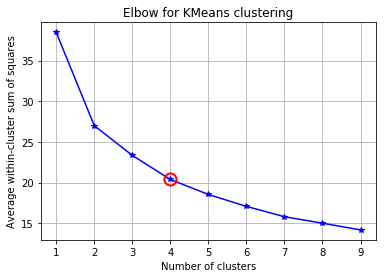

In [33]:
centroid_list = []
for i in range(1,10):
    clust_labels, cent = MakeKmeans(df_full[['Sp. Atk','Speed']], i)
    X = df_full[['Sp. Atk','Speed']]
    model = KMeans(n_clusters=i)
    model.fit(X)
    clust_labels = model.predict(X)
    centroids = model.cluster_centers_
    centroid_list.append(centroids)

D_k = [cdist(df_full[['Sp. Atk','Speed']].values, cent, 'euclidean') for cent in centroid_list]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,10), avgWithinSS, 'b*-')

ax.plot([4], avgWithinSS[3], marker='o',
        markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')

plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

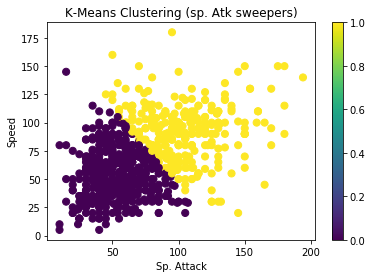

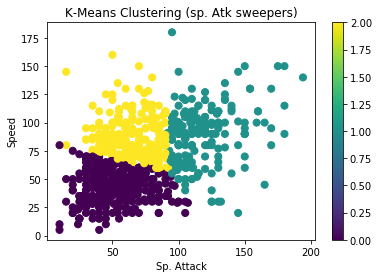

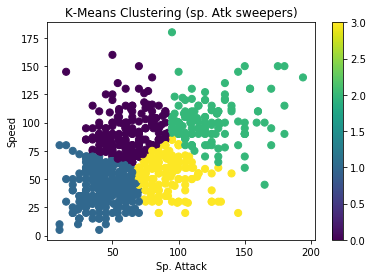

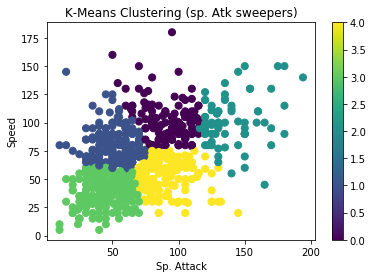

In [32]:
#A look at 2 to 5 clusters, which is visually illustrates what the elbow plot was showing
#(that 5 clusters is probably one too many)
for i in range(2,6):
    clust_labels, cent = MakeKmeans(df_full[['Sp. Atk','Speed']], i)
    X = df_full[['Sp. Atk','Speed']]
    model = KMeans(n_clusters=i)
    model.fit(X)
    clust_labels = model.predict(X)
    centroids = model.cluster_centers_
    kmeans = pd.DataFrame(clust_labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_full['Sp. Atk'],df_full['Speed'],c=kmeans[0],s=50)
    ax.set_title('K-Means Clustering (sp. Atk sweepers)')
    ax.set_xlabel('Sp. Attack')
    ax.set_ylabel('Speed')
    plt.colorbar(scatter)
plt.show()

<h3>K means clustering</h3>
Work in progress

<h3>Bonus: T distributed Stochastic Neighbour Embedding</h3>
PCA allows us to make use of all of the data, not a limited few dimensions. It is more difficult to interpret however and beyond the scope of this kernel. I'm putting it here just so people know it exists.

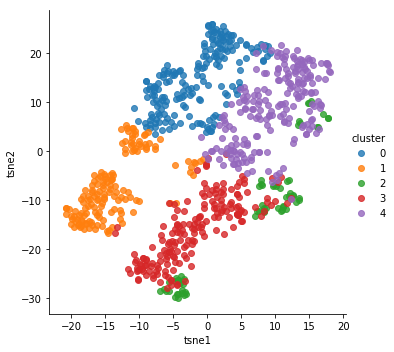

In [8]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df_full[features]
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=11)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)